# PySINDy Exploration & Applications

## COLSA Corporation 

### Raj Garkhedkar, DACS Lab Summer 2021 Intern

## Waves


-- -- -- -- -- --
###### Links 

[Reflected Sound Discriminator](https://github.com/diabelmehdi/Machine_Learning_project/blob/master/realiz/Documentation/machine%20learning%20report_DIAB_ELMEHDI.pdf)

[Deep Learning Machine Solves the Cocktail Party Problem](https://www.technologyreview.com/2015/04/29/168316/deep-learning-machine-solves-the-cocktail-party-problem/)

[Deep Karaoke: Extracting Vocals](https://arxiv.org/abs/1504.04658)

[Diff Eq's in Physics](https://olewitthansen.dk/Physics/differential_equations_of_physics.pdf)

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animate
import matplotlib.colors as colors
import ipywidgets
import PDE_FIND as pdefind
from matplotlib.colors import LightSource
from matplotlib import interactive

## Advection - Diffusion PDE
-- -- --
The equation: 
$$u_t + a u_x = \epsilon u_{xx}$$

This might be the density or concentration of some substance and how the energy, particles, or some other physical quantity is transferred in a physical system through two processes: _diffusion and advection_. The subscripts denote partial differentiation; e.g. $u_t$ is the partial derivative of $u$ with respect to $t$. The coefficients $a$ and $\epsilon$ are constants that determine the strength of the advective and diffusive effects. We wish to find $u(x,t)$. Depending on context, the same equation can be called the advection–diffusion equation, drift–diffusion equation, or scalar transport equation.

In [2]:
2*np.pi

6.283185307179586

In [20]:
# Spatial grid
m = 64                            # Number of grid points in space
L = 2 * np.pi                     # Width of spatial domain
x = np.arange(-m/2,m/2)*(L/m)   # Grid points 
dx = x[1]-x[0]                  # Grid spacing

# Temporal grid
tmax = 8.0     # Final time
N = 50       # number grid points in time
k = tmax/N   # interval between output times

xi = np.fft.fftfreq(m)*m*2*np.pi/L  # Wavenumber "grid"

# Initial data
u = np.sin(2*x)**2 * (x<-L/4)
uhat0 = np.fft.fft(u)

The functions $u, \hat{u}$ discussed above are replaced by finite-dimensional vectors. These vectors are related through the discrete version of the Fourier transform(DFT). 

Initial conditions:

$$u_0(x) = \begin{cases} \sin^2(2x) & -\pi \le x < -\pi/2 \\ 0 & x>-\pi/2 \end{cases}$$

In [34]:
epsilon=0.4  # Diffusion coefficient
a = 1.0       # Advection coefficient

<IPython.core.display.Javascript object>


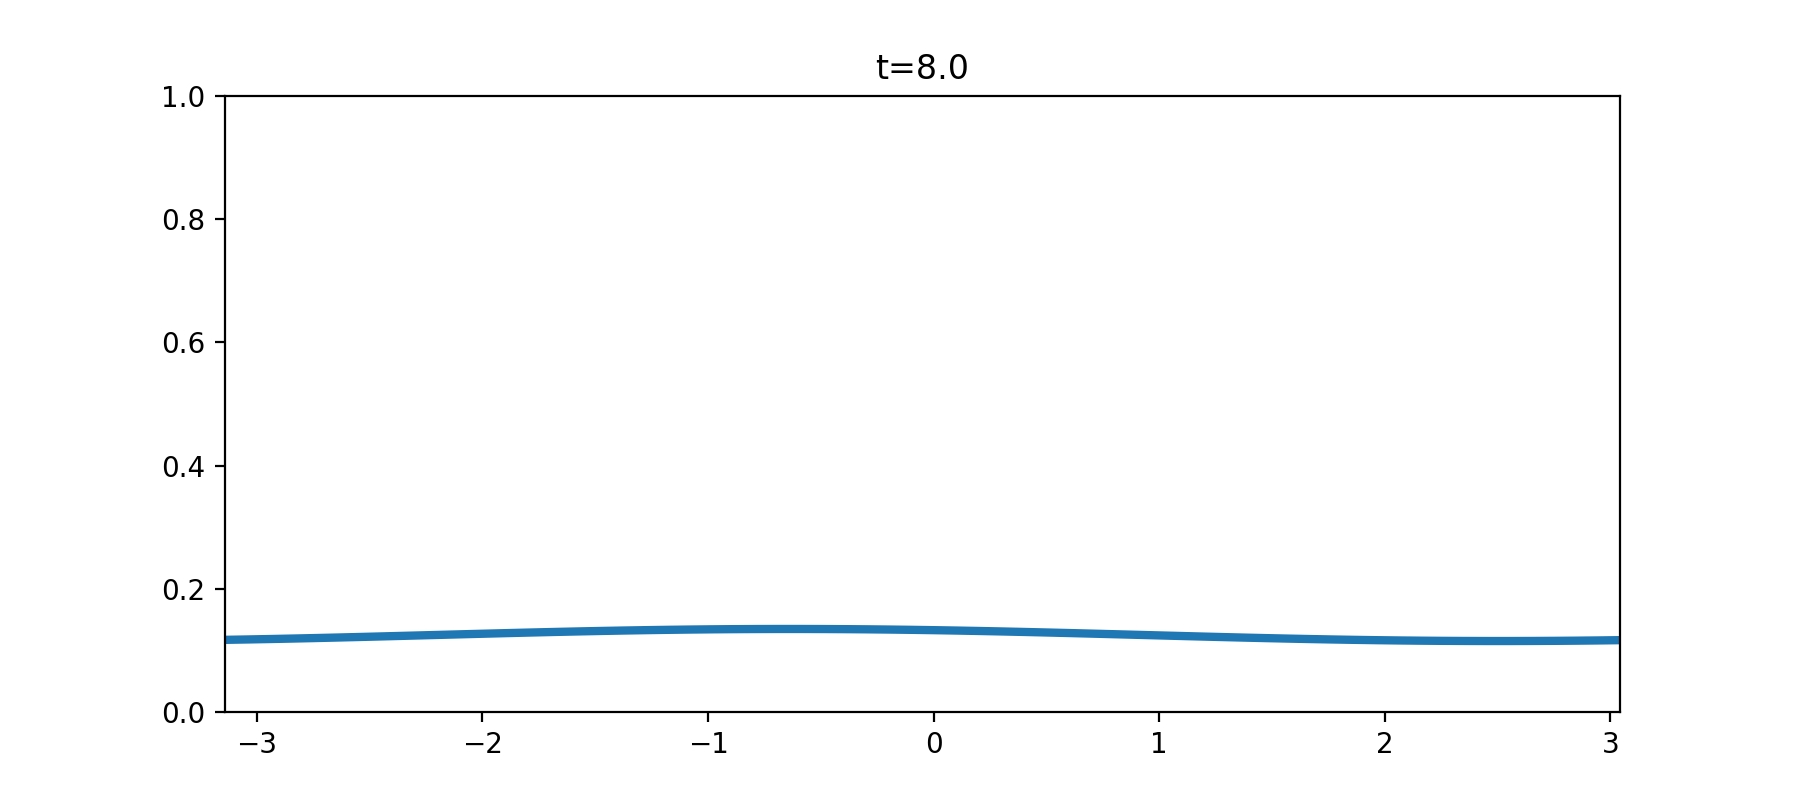

In [35]:
# Store solutions in a list for plotting later
frames = [u.copy()]

# Now we solve the problem
for n in range(1,N+1):
    t = n*k
    uhat = np.exp(-(1.j*xi*a + epsilon*xi**2)*t) * uhat0
    u = np.real(np.fft.ifft(uhat))
    frames.append(u.copy())

# Set up plotting
fig = plt.figure(figsize=(9,4)); axes = fig.add_subplot(111)
line, = axes.plot([],[],lw=3)
axes.set_xlim((x[0],x[-1])); axes.set_ylim((0.,1.))

def plot_frame(i):
    line.set_data(x,frames[i])
    axes.set_title('t='+str(i*k))
    fig.canvas.draw()
    return fig

# Animate the solution
animation = animate.FuncAnimation(fig, plot_frame,
                                   frames=len(frames),
                                   interval=350,
                                   repeat=False)

The first approximation was to take the initial data and approximate it by just the first terms in its Fourier series. The vector $\hat{u}$ contains the first 64 Fourier modes (because 64 points are in the spatial grid vector $x$).

The time evolution of the solution is exact for the initial data vector, since it uses the exact solution formula for the ODE above.

### For Generality...
This methodology can be used to solve any linear evolution PDE (including systems of PDEs, like the following scalar PDEs):

$$u_t = \sum_{j=0}^n \alpha_j \frac{\partial^j u}{\partial x^j}.$$
Taking Fourier transform or applying our ansatz:
$$u(x,t; \xi) = \hat{u}(t) e^{i\xi x},$$
The following linear ODE is obtained:
$$\hat{u}'(t) = \left(\sum_{j=0}^n \alpha_j (i\xi)^j\right) \hat{u}(t) = p(\xi)\hat{u}(t)$$
With solution:
$$\hat{u}(t) = e^{p(\xi)t}\hat{u}(0)$$
so that
$$u(x,t; \xi) = e^{i\xi x + p(\xi)t} \hat{u}(0).$$
Here $p(\xi)$ is a polynomial with coefficients $i^j \alpha_j$.

The odd-derivative terms correspond to imaginary terms in $p(\xi)$, which (in the exponential) lead to changes in the phase of the solution, while even-derivative terms correspond to real terms in $p(\xi)$, which lead to changes in the amplitude of the solution.

In [7]:
[len(a) for a in frames][0]

64

In [8]:
framearray = np.asarray(frames)
framearray.shape

(51, 64)

In [32]:
framearray.shape

(51, 64)

In [9]:
Ut, R, rhs_des = pdefind.build_linear_system(framearray, k, dx, D=2, P=2, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}']

In [10]:
# Solve with STRidge
w = pdefind.TrainSTRidge(R,Ut,10**-5,1)
print("PDE derived using STRidge")
pdefind.print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-0.361538 +0.000000i)u_{x}
    + (0.009529 +0.000000i)u_{xx}
   


/Users/rajgark/Documents/GitHub/COLSA-PySINDy/PDE_FIND.py:430: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
/Users/rajgark/Documents/GitHub/COLSA-PySINDy/PDE_FIND.py:575: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
/Users/rajgark/Documents/GitHub/COLSA-PySINDy/PDE_FIND.py:601: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the i

In [12]:
def discrete_laplacian(u, bdy):
    if bdy == 'Periodic':
        L = -4*u
        L += np.roll(u, (0,-1), (0,1))
        L += np.roll(u, (0,+1), (0,1))
        L += np.roll(u, (-1,0), (0,1))
        L += np.roll(u, (+1,0), (0,1))
        return L
    elif bdy == 'Dirichlet':
        v = np.pad(u, 1, constant_values=0)
    elif bdy == 'Neumann':
        v = np.pad(u, 1, mode='edge')
    L = -4*v
    L += np.roll(v, (0,-1), (0,1))
    L += np.roll(v, (0,+1), (0,1))
    L += np.roll(v, (-1,0), (0,1))
    L += np.roll(v, (+1,0), (0,1))
    L = L[1:-1,1:-1]
    return L

def leapfrog(u0, um, cfl, bdy):
    up = 2*u0 - um + cfl**2*discrete_laplacian(u0, bdy)
    return up, u0

def define_initial_condition(f, g, dt, bdy):
    u0 = f + 0.5*cfl**2*discrete_laplacian(f, bdy) + dt*g
    return u0, f

def update_solution(f, g, cfl, dt, bdy, Nframes, Nskip):
    n = 0
    u0, um = define_initial_condition(f, g, dt, bdy)
    while n<Nframes:
        n += 1
        for k in range(Nskip):
            u0, um = leapfrog(u0, um, cfl, bdy)
        yield u0

def update_graph(u, ls, imu):
    imu.set_array(ls.hillshade(u))

<IPython.core.display.Javascript object>


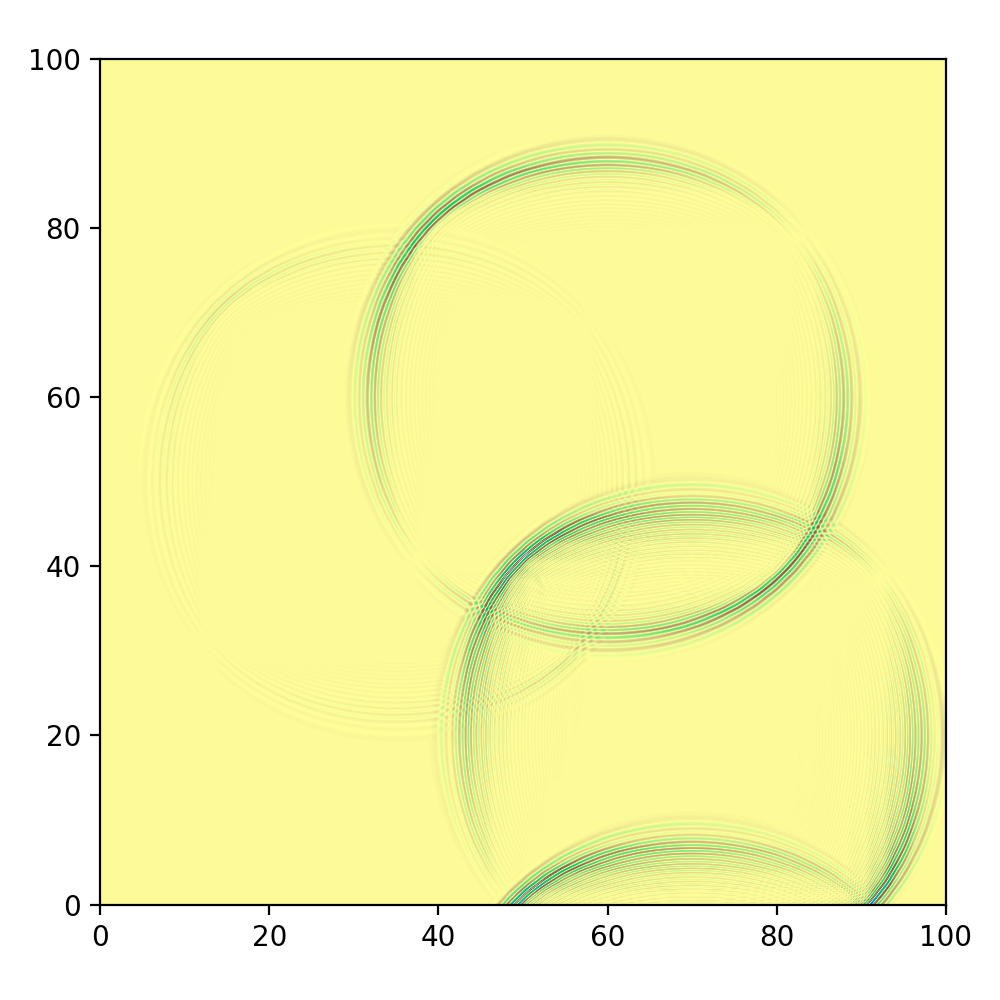

In [13]:
# model parameter
c = 1       # speed constant
L = 100      # domain length

# numerical parameters
N = 800    # grid size

# define a function that simulates a raindrop
def pebble(X, Y, width, positionX, positionY):
    r = width*np.sqrt((X-positionX)**2 + (Y-positionY)**2)
    u = np.random.uniform(-1., 1., 1)*np.cos(1.9*r)/np.cosh(r)
    return u

x = np.linspace(0, L, N)
X, Y = np.meshgrid(x, x)

# initial displacement consists of three separate raindrops 
f =  pebble(X, Y, 3.5, 0.35*L, 0.5*L)
f += pebble(X, Y, 3, 0.6*L, 0.6*L)
f += pebble(X, Y, 4, 0.7*L, 0.2*L)

# initial velocity is zero
g = np.zeros((N,N))

# animation parameters
Nsteps = 400
Nskip = 10

# set time step to satisfy leapfrog stability criterion (cfl < 1/sqrt(2) ~ 0.7)
cfl = 0.6
dx = L/N
dt = cfl * dx / c
#dt = 0.00001

# compute and animate solution
Nframes = int(Nsteps/Nskip)
extent = [0, L, 0, L]

fig, ax = plt.subplots(1,1,figsize=(5,5))
ls = LightSource(azdeg=220, altdeg=70)
imu = ax.imshow(ls.hillshade(f), cmap='terrain', animated=True, extent=extent, origin='lower')
ani = animate.FuncAnimation(fig, update_graph,
                              update_solution(f, g, cfl, dt, 'Neumann', Nframes, Nskip),
                              fargs=(ls, imu), repeat=False)
plt.tight_layout()
plt.show()

In [14]:
f.shape

(800, 800)

In [15]:
Ut, R, rhs_des = pdefind.build_linear_system(f, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')

In [16]:
['1']+rhs_des[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}']

In [17]:
# w = pdefind.TrainSTRidge(R,Ut,10**-5,5)
# print("PDE derived using STRidge")
# pdefind.print_pde(w, rhs_des)